# 毕业项目：检测分神司机

In [1]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import os, shutil
import random
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.utils import to_categorical
from keras import regularizers

from keras.applications import vgg16
from keras.applications.vgg16 import VGG16


import pydot
import cv2
import h5py

Using TensorFlow backend.


In [2]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')
image_valid_folder_path = join(pardir, 'data', 'driver_dataset', 'valid')

vgg16_train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    preprocessing_function=vgg16.preprocess_input)

vgg16_valid_datagen = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input)


vgg16_train_generator = vgg16_train_datagen.flow_from_directory(
    image_train_folder_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

vgg16_valid_generator = vgg16_valid_datagen.flow_from_directory(
    image_valid_folder_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

Found 20097 images belonging to 10 classes.
Found 2327 images belonging to 10 classes.


### 二、创建模型

In [3]:
model_vgg16 = VGG16(include_top=False, weights='imagenet')

for i, layer in enumerate(model_vgg16.layers):
    print (i, layer.name)
        
input = Input(shape=(224, 224, 3),name = 'image_input')
 
output_vgg16_conv = model_vgg16(input)
   
x = Flatten()(output_vgg16_conv)
x = Dense(1048, activation='relu')(x)
x = Dense(1048, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


### 三、模型创建
#### 1.不锁定Vgg16模型所有层

In [4]:
model = Model(inputs=input, outputs=x)
    
adam = optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [5]:
history = model.fit_generator(
    vgg16_train_generator,
    epochs=10,
    validation_data=vgg16_valid_generator)

Epoch 1/10


KeyboardInterrupt: 

In [10]:
model.save(join(pardir, 'model', 'vgg16_finetune.h5'))
print("Vgg16 model saved.")

Vgg16 model saved.


{'val_categorical_accuracy': [0.7864202833452294, 0.8835410400936928, 0.8620541469959625, 0.8414267297205005, 0.8096261278825816, 0.8560378168548286, 0.8461538461794605, 0.8586162439118038, 0.9054576708464137, 0.8904168456472652], 'loss': [1.3762711689247624, 0.17970604248982186, 0.07545571456861512, 0.04968549411674321, 0.03750200277811707, 0.0441216169471181, 0.030087501375292806, 0.024934399633896858, 0.027923820113157347, 0.01697088883288594], 'categorical_accuracy': [0.48076827387172216, 0.9449171518137035, 0.9774095636164601, 0.9859680549335722, 0.9887047818082301, 0.9872120216947803, 0.9908444046375081, 0.9914912673533364, 0.9921878887396128, 0.9949743742847191], 'val_loss': [0.5568196273024214, 0.4111736760817734, 0.4837117040674728, 0.657333962596892, 0.7824442623688215, 0.49386287549111174, 0.5958138087392274, 0.7292638206374193, 0.5745205466476836, 0.46433353308962677]}


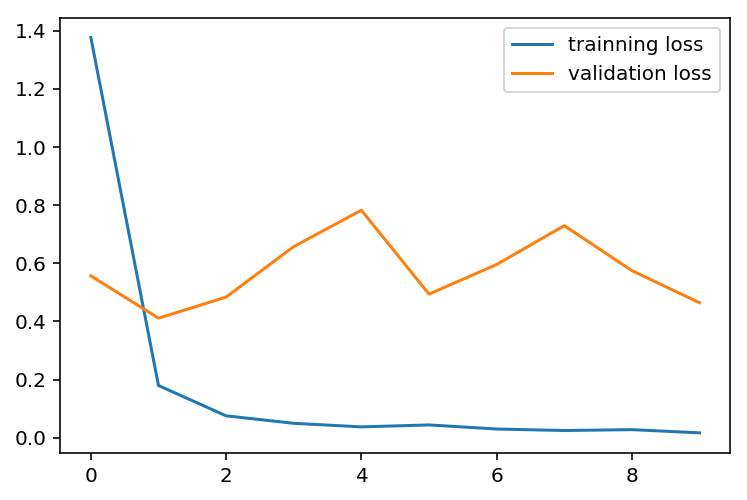

In [11]:
print (history.history)
plt.plot (history.history['loss'], label="trainning loss")
plt.plot (history.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

#### 2.锁定Vgg16模型前18层

In [6]:
model_10 = Model(inputs=input, outputs=x)

for i in range(18):
    model_vgg16.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_10.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [7]:
history_10 = model_10.fit_generator(
    vgg16_train_generator,
    epochs=10,
    validation_data=vgg16_valid_generator)

Epoch 1/10
315/315 [==============================] - 264s 838ms/step - loss: 4.5701 - categorical_accuracy: 0.6723 - val_loss: 5.2245 - val_categorical_accuracy: 0.6266
Epoch 2/10
315/315 [==============================] - 253s 803ms/step - loss: 2.3153 - categorical_accuracy: 0.8336 - val_loss: 3.5897 - val_categorical_accuracy: 0.7082
Epoch 3/10
315/315 [==============================] - 252s 801ms/step - loss: 1.9138 - categorical_accuracy: 0.8699 - val_loss: 3.6178 - val_categorical_accuracy: 0.7202
Epoch 4/10
315/315 [==============================] - 253s 802ms/step - loss: 1.8675 - categorical_accuracy: 0.8746 - val_loss: 3.2424 - val_categorical_accuracy: 0.7439
Epoch 5/10
315/315 [==============================] - 254s 806ms/step - loss: 1.9226 - categorical_accuracy: 0.8720 - val_loss: 3.7684 - val_categorical_accuracy: 0.7215
Epoch 6/10
315/315 [==============================] - 252s 799ms/step - loss: 1.8626 - categorical_accuracy: 0.8766 - val_loss: 4.0957 - val_categoric

In [19]:
model_10.save(join(pardir, 'model', 'vgg16_finetune_18.h5'))
print("Vgg16 model saved.")

Vgg16 model saved.


{'categorical_accuracy': [0.6712444643479126, 0.8330596606458676, 0.8695327660844903, 0.8741603224361845, 0.8747076678111161, 0.8762004279245659, 0.8773448773448773, 0.8810270189580535, 0.8785390854356372, 0.8478877444394686], 'val_loss': [5.22454833943392, 3.5896541736235577, 3.6178142057245877, 3.242446909843916, 3.7684430481284075, 4.09566396191159, 3.2457307279161487, 3.8422886381653383, 3.7348682976086365, 4.126269716124295], 'loss': [4.584336412512331, 2.3225442598178896, 1.9198133224111567, 1.873334987244096, 1.8782855501434497, 1.868372355852992, 1.859688530367109, 1.8245985706261676, 1.8647820704271787, 2.325317962220541], 'val_categorical_accuracy': [0.6265577997677717, 0.7082079932522661, 0.7202406534320764, 0.7438762357012622, 0.7215298666019628, 0.690159002726407, 0.7606360120326601, 0.7163730122062543, 0.7327030511644197, 0.7215298668068778]}


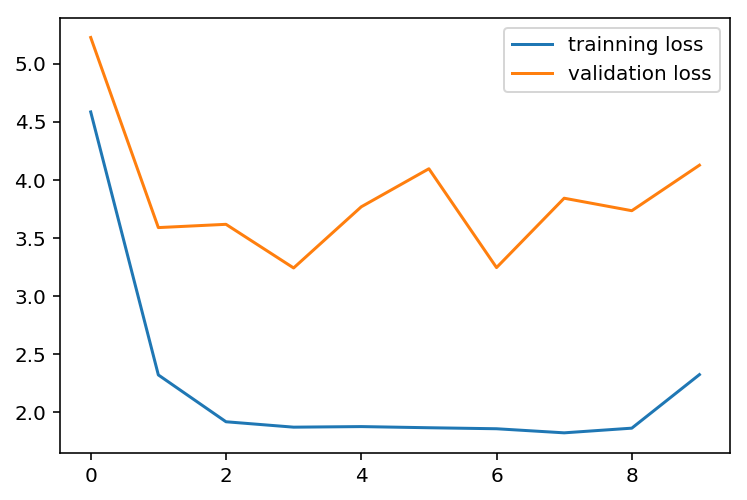

In [9]:
print (history_10.history)
plt.plot (history_10.history['loss'], label="trainning loss")
plt.plot (history_10.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

### 四、模型预测
准备测试集数据

In [13]:
test_image_path = join(driver_dataset_folder_path, 'test')
vgg16_test_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
vgg16_test_generator = vgg16_test_datagen.flow_from_directory(
    test_image_path,
    target_size=(224, 224),
    batch_size=128,
    shuffle=False,
    class_mode='categorical')

Found 79726 images belonging to 1 classes.


#### 1.model_Vgg16_finetune
模型加载

In [11]:
model_vgg16_finetune = load_model(join(pardir, 'model', 'vgg16_finetune.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [14]:
pred_vgg16_finetune = model_vgg16_finetune.predict_generator(vgg16_test_generator, verbose=1)
print(pred_vgg16_finetune.shape)

623/623 [==============================] - 818s 1s/step
(79726, 10)


生成kaggle提交文件

In [15]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [16]:
result_vgg16_finetune = np.append(image_names, pred_vgg16_finetune, axis = 1)
predict_result_vgg16_finetune = pd.DataFrame(result_vgg16_finetune, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_vgg16_finetune.to_csv('result_vgg16_finetune.csv', index=False)

#### 2.model_Vgg16_finetune_10
模型加载

In [21]:
model_vgg16_finetune_18 = load_model(join(pardir, 'model', 'vgg16_finetune_18.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [22]:
pred_vgg16_finetune_18 = model_vgg16_finetune_18.predict_generator(vgg16_test_generator, verbose=1)
print(pred_vgg16_finetune_18.shape)

623/623 [==============================] - 807s 1s/step
(79726, 10)


生成kaggle提交文件

In [23]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [24]:
result_vgg16_finetune_18 = np.append(image_names, pred_vgg16_finetune_18, axis = 1)
predict_result_vgg16_finetune_18 = pd.DataFrame(result_vgg16_finetune_18, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_vgg16_finetune_18.to_csv('result_vgg16_finetune_18.csv', index=False)